# Selecting features with unlabeled data

Feature selection is a way of selecting the subset of the most relevant features from the original features set by removing the redundant, irrelevant, or noisy features. In this study, we compare two feature selection method: (1) Variance Threshold, and (2) Laplacian score, and evaluate them with the DBSCAN clustering algorithm. We select potential set of features by removing candidate features below the median score as it benefits from reduction in memory and computations, and can improve generalization and interpretability [Lindenbaum et al. (2021)](https://proceedings.neurips.cc/paper/2021/file/0bc10d8a74dbafbf242e30433e83aa56-Paper.pdf).

Selection of feature vectors are generated in four phases:
- Calculation of the Descriptive Features and MFCCs
- Normalization of the features values adjusted to the same dynamic range (0, 1) so that each feature has equal significance to the classification result
- Ranking of candidate features with respect to a score which measures their relevance
- Removing of candidate features below the median score to fasten the calculation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage ,fcluster
from collections import Counter

from sklearn import preprocessing
from sklearn.metrics.cluster import adjusted_rand_score
import itertools
import random
from scipy.spatial import distance as ssd
from tqdm import tqdm
import scipy
import scipy.sparse 
from scipy.stats import pearsonr
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph 
from scipy.sparse.linalg import expm
from scipy.linalg import solve_banded
from scipy.spatial.distance import pdist
import scipy.spatial.distance
import math
from sklearn.metrics.pairwise import euclidean_distances
import sklearn
import os.path

Load the `dataset.csv` file

In [2]:
df = pd.read_csv('dataset.csv')
df_features = df.iloc[:, 8:] # Keep only the features in the dataset
print(f'Number of features: {df_features.shape[1]}')
print(f'Number of rows: {len(df_features.index)}\n')
df_features.head()

Number of features: 27
Number of rows: 4133



,duration,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,SCm,SCv,SBm,SBv,SFm,SFv,SRm,SRv,SFMm,SFMv
0,0.549,-109.481958,2.474112,48.374942,-20.190026,-21.349509,22.027669,4.836637,-19.319112,10.261311,...,4704.694674,357332.539106,1709.182879,49979.930391,0.888162,1.008821,6320.443726,1.303338e+06,0.002201,0.000019
1,0.571,-124.321819,-13.316125,55.665256,-7.335846,-24.810362,7.351164,10.126267,-2.886359,-6.360926,...,4894.594990,123823.953408,1903.750012,16588.690002,1.478772,1.929453,6885.457031,4.002580e+05,0.005412,0.000030
2,0.581,-118.811872,-16.306968,55.360652,-6.264549,-24.322579,6.051968,11.284524,-4.387789,-5.237668,...,4699.412453,190309.299218,1817.679751,27431.162664,1.482830,2.016139,6284.382512,8.548969e+05,0.009392,0.000515
3,0.562,-123.582189,-13.492028,56.402909,-7.246422,-27.307025,10.241175,9.205721,-2.900979,-6.563202,...,4807.354395,102161.378437,1904.473960,14730.848980,1.487784,2.005177,6751.089844,5.392537e+05,0.004954,0.000042
4,0.512,-118.616751,-12.580760,54.472028,-7.582635,-26.822244,10.891599,9.429326,-4.431579,-5.880217,...,4798.271899,162268.012722,1917.163729,27450.507078,1.588638,2.743882,6797.470491,9.439857e+05,0.006289,0.000105


### Feature selection

Among the feature selection techniques, we were particularly interested in those based on individual ranking. These algorithms rank the candidate features with respect to a score which measures their relevance. In the unsupervised context, selection of features are usually done using Variance Threshold and Laplacian score ([H. X. et al., 2005](https://proceedings.neurips.cc/paper/2005/file/b5b03f06271f8917685d14cea7c6c50a-Paper.pdf)).

#### Variance Threshold

Variance shows the variability in the distribution of a single metric. It shows how spread out the distribution is and shows the average squared distance from the mean. Often, it is not fair to compare the variance of a feature to another. The reason is that as the values in the distribution get bigger, the variance grows exponentially. In other words, the variances will not be on the same scale. Therefore, we can normalize all features between a given range of 0 and 1. This method will ensures that all variances are on the same scale.

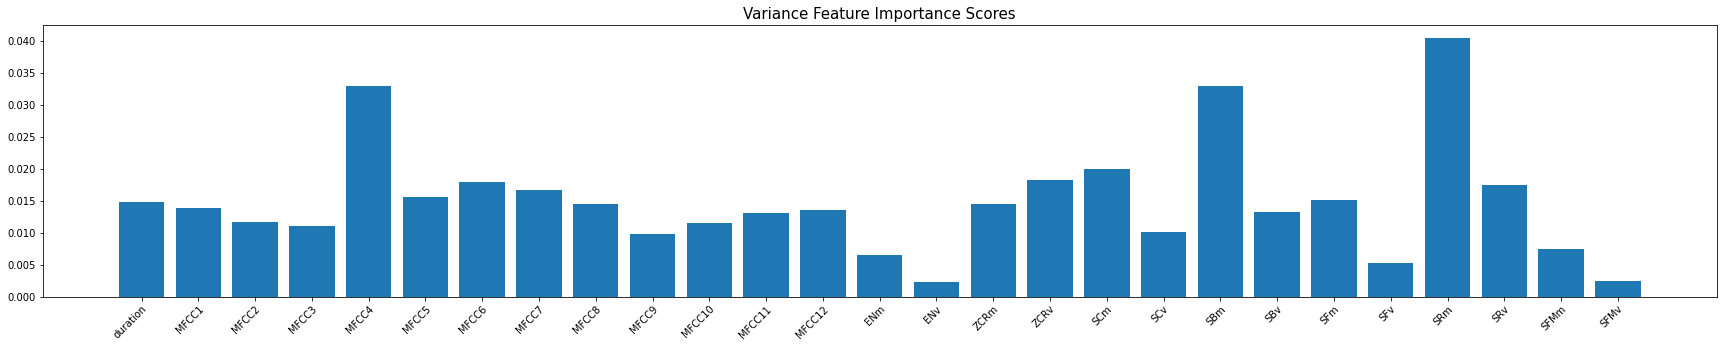

In [3]:
# Create a scaler object
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
# Apply scaler object to normalize audio features between 0 and 1
normalize_features = scaler.fit_transform(df_features)

# Create a feature selector using variance
selector = VarianceThreshold()
var_features = selector.fit_transform(normalize_features)

fig, ax = plt.subplots(figsize=(30,5))
ax.set_title('Variance Feature Importance Scores', size=15)
ax.bar(np.arange(var_features.shape[1]), selector.variances_)
ax.set_xticks(np.arange(len(df_features.columns)), labels=df_features.columns)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

In [4]:
# Keep features above the median and sort them in descending order
max_var = np.argsort(selector.variances_)[::-1]
median = np.where((selector.variances_[max_var] > np.median(selector.variances_)) == True)[0].size

# Create dataframe with the 10 selected audio features 
selected = df_features.iloc[:, max_var[:median]]

print(f'Number of features with maximum variance in descending order: {selected.shape[1]}\n')
selected.head()

Number of features with maximum variance in descending order: 13



,SRm,SBm,MFCC4,SCm,ZCRv,MFCC6,SRv,MFCC7,MFCC5,SFm,duration,ZCRm,MFCC8
0,6320.443726,1709.182879,-20.190026,4704.694674,0.006017,22.027669,1.303338e+06,4.836637,-21.349509,0.888162,0.549,0.393921,-19.319112
1,6885.457031,1903.750012,-7.335846,4894.594990,0.003867,7.351164,4.002580e+05,10.126267,-24.810362,1.478772,0.571,0.393008,-2.886359
2,6284.382512,1817.679751,-6.264549,4699.412453,0.005324,6.051968,8.548969e+05,11.284524,-24.322579,1.482830,0.581,0.404259,-4.387789
3,6751.089844,1904.473960,-7.246422,4807.354395,0.002509,10.241175,5.392537e+05,9.205721,-27.307025,1.487784,0.562,0.385762,-2.900979
4,6797.470491,1917.163729,-7.582635,4798.271899,0.004203,10.891599,9.439857e+05,9.429326,-26.822244,1.588638,0.512,0.391667,-4.431579


In [5]:
selected.columns

Index(['SRm', 'SBm', 'MFCC4', 'SCm', 'ZCRv', 'MFCC6', 'SRv', 'MFCC7', 'MFCC5',
       'SFm', 'duration', 'ZCRm', 'MFCC8'],
      dtype='object')

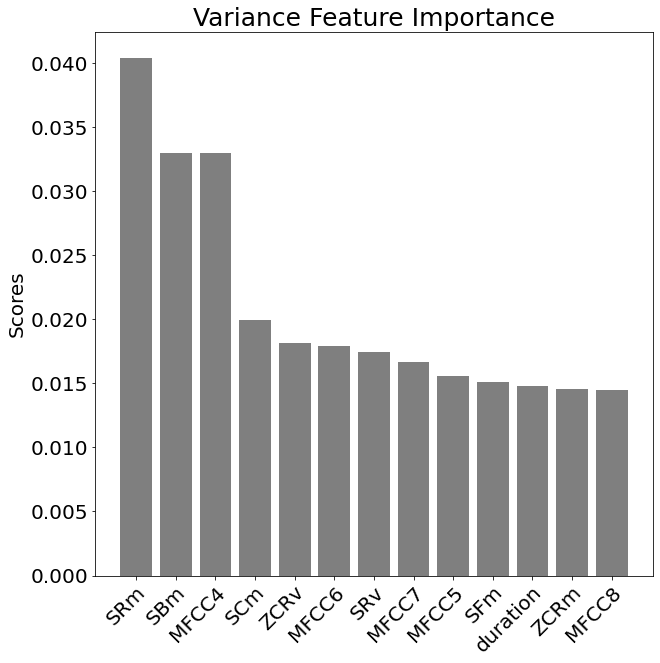

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Variance Feature Importance', size=25)
ax.bar(np.arange(selected.shape[1]), selector.variances_[max_var[:median]], color='black', alpha=0.5)
ax.set_xticks(np.arange(len(selected.columns)), labels=selected.columns, fontsize=20)
# Rotate the tick labels and set their alignment.
ax.set_ylabel('Scores', fontsize=20)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(fontsize=20);
# plt.savefig('variance.jpg')

#### Mean Absolute Difference score

The Mean Absolute Difference (univariate) is a measure of statistical dispersion equal to the average absolute difference of two independent values drawn from a probability distribution. A related statistic is the relative mean absolute difference, which is the mean absolute difference divided by the arithmetic mean, and equal to twice the Gini coefficient. The mean absolute difference is also known as the absolute mean difference (not to be confused with the absolute value of the mean signed difference) and the Gini mean difference (GMD).

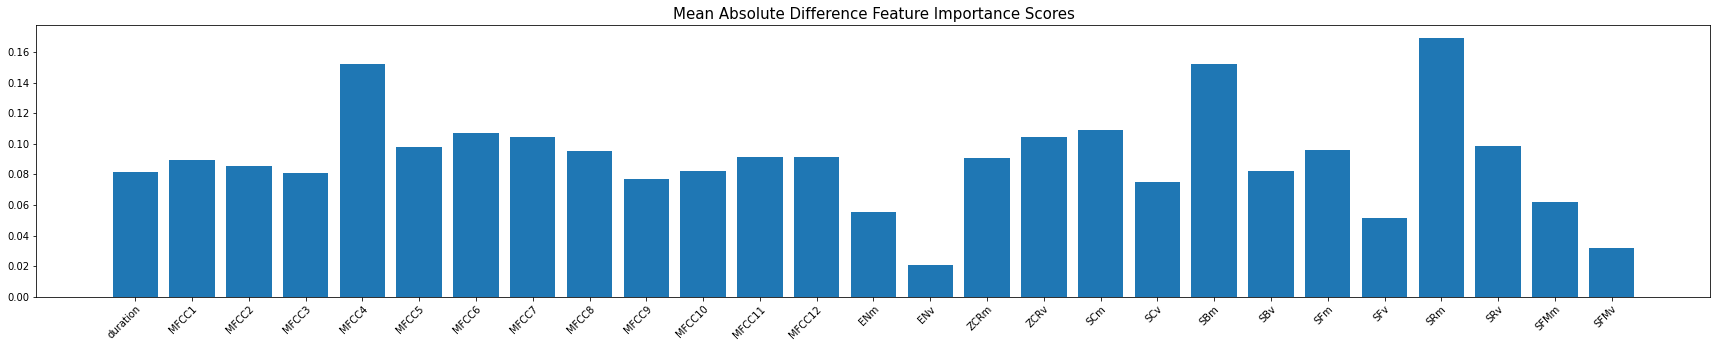

In [8]:
mad = np.sum(np.abs(normalize_features - np.mean(normalize_features, axis=0)), axis=0) / normalize_features.shape[0]

fig, ax = plt.subplots(figsize=(30,5))
ax.set_title('Mean Absolute Difference Feature Importance Scores', size=15)
ax.bar(np.arange(normalize_features.shape[1]), mad)
ax.set_xticks(np.arange(len(df_features.columns)), labels=df_features.columns)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

In [9]:
max_mad = np.argsort(mad)[::-1]
selected = df_features.iloc[:, max_mad]
print(f'Number of features with maximum mean absolute error in descending order: {selected.shape[1]}\n')
selected.head()

Number of features with maximum mean absolute error in descending order: 27



,SRm,MFCC4,SBm,SCm,MFCC6,MFCC7,ZCRv,SRv,MFCC5,SFm,...,MFCC10,duration,MFCC3,MFCC9,SCv,SFMm,ENm,SFv,SFMv,ENv
0,6320.443726,-20.190026,1709.182879,4704.694674,22.027669,4.836637,0.006017,1.303338e+06,-21.349509,0.888162,...,4.144050,0.549,48.374942,10.261311,357332.539106,0.002201,0.010297,1.008821,0.000019,0.000271
1,6885.457031,-7.335846,1903.750012,4894.594990,7.351164,10.126267,0.003867,4.002580e+05,-24.810362,1.478772,...,3.639805,0.571,55.665256,-6.360926,123823.953408,0.005412,0.004892,1.929453,0.000030,0.000033
2,6284.382512,-6.264549,1817.679751,4699.412453,6.051968,11.284524,0.005324,8.548969e+05,-24.322579,1.482830,...,4.367636,0.581,55.360652,-5.237668,190309.299218,0.009392,0.004475,2.016139,0.000515,0.000030
3,6751.089844,-7.246422,1904.473960,4807.354395,10.241175,9.205721,0.002509,5.392537e+05,-27.307025,1.487784,...,3.012145,0.562,56.402909,-6.563202,102161.378437,0.004954,0.005410,2.005177,0.000042,0.000044
4,6797.470491,-7.582635,1917.163729,4798.271899,10.891599,9.429326,0.004203,9.439857e+05,-26.822244,1.588638,...,4.009962,0.512,54.472028,-5.880217,162268.012722,0.006289,0.004970,2.743882,0.000105,0.000044


#### Laplacian score

In the unsupervised learning context, we are not given class labels, therefore it is complicated to know which features to keep. Unsupervised feature selection method well solves this problem and has got a good effect in features selection with unlabeled data. Laplacian Score (LS) has shown great help to selecting the best features of an unsupervised learning algorithm ([He, X. et al., 2005](https://proceedings.neurips.cc/paper/2005/file/b5b03f06271f8917685d14cea7c6c50a-Paper.pdf)). Code implementation from [scikit-feature](https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/similarity_based/lap_score.py) and [Madalina Ciortan](https://github.com/ciortanmadalina)

In [10]:
def construct_W(X, neighbour_size=15, t=1):
    n_samples, n_features = np.shape(X)
    S = kneighbors_graph(X, neighbour_size + 1, mode='distance', metric='euclidean') #sqecludian distance works only with mode=connectivity  results were absurd
    S = (-1*(S*S)) / (2*t*t)
    S = S.tocsc()
    S = expm(S) # exponential
    S = S.tocsr()
    #[1]  M. Belkin and P. Niyogi, “Laplacian Eigenmaps and Spectral Techniques for Embedding and Clustering,” Advances in Neural Information Processing Systems,
    #Vol. 14, 2001. Following the paper to make the weights matrix symmetrix we use this method
    bigger = np.transpose(S) > S
    S = S - S.multiply(bigger) + np.transpose(S).multiply(bigger)
    return S

def LaplacianScore(X, neighbour_size=15, t=1):
    W = construct_W(X,t=t,neighbour_size=neighbour_size)
    n_samples, n_features = np.shape(X)
    
    #construct the diagonal matrix
    D = np.array(W.sum(axis=1))
    D = scipy.sparse.diags(np.transpose(D), [0])
    #construct graph Laplacian L
    L = D-W.toarray()

    #construct 1= [1,···,1]' 
    I=np.ones((n_samples,n_features))

    #construct fr' => fr= [fr1,...,frn]'
    Xt = np.transpose(X)

    #construct fr^=fr-(frt D I/It D I)I
    t = np.matmul(np.matmul(Xt,D.toarray()),I)/np.matmul(np.matmul(np.transpose(I),D.toarray()),I)
    t = t[:,0]
    t = np.tile(t,(n_samples,1))
    fr = X-t

    #Compute Laplacian Score
    fr_t = np.transpose(fr)
    Lr = np.matmul(np.matmul(fr_t,L),fr)/np.matmul(np.dot(fr_t,D.toarray()),fr)

    return np.diag(Lr)

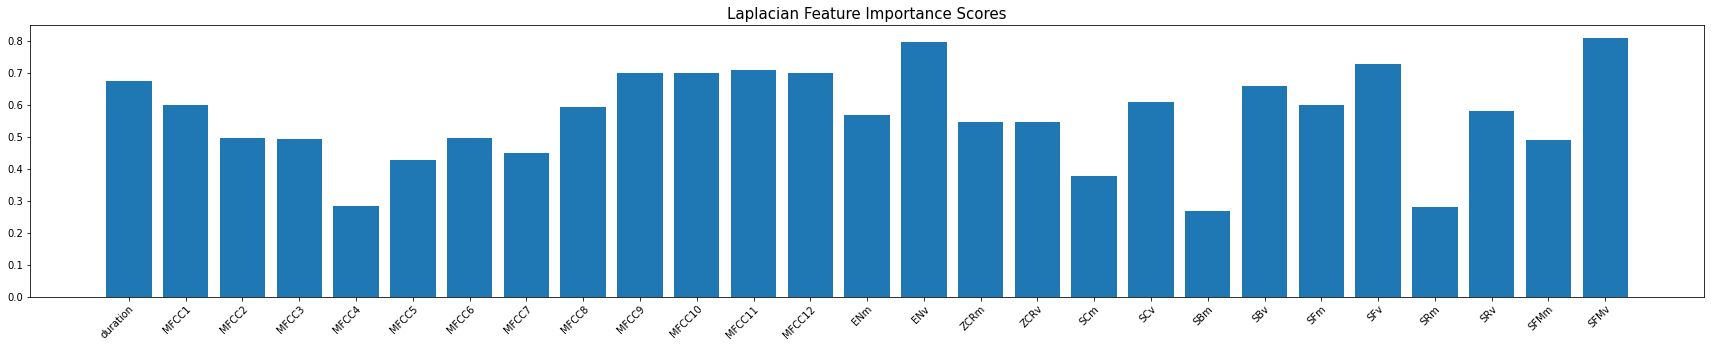

In [11]:
ls = LaplacianScore(normalize_features)

fig, ax = plt.subplots(figsize=(30,5))
ax.set_title('Laplacian Feature Importance Scores', size=15)
ax.bar(np.arange(df_features.shape[1]), ls)
ax.set_xticks(np.arange(len(df_features.columns)), labels=df_features.columns)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

In [13]:
laplacian = np.argsort(ls)
idx = np.where((ls[laplacian] > np.median(ls)) == True)[0].size

# Create dataframe with the 10 selected audio features 
selected = df_features.iloc[:, laplacian[:idx]]
print(f'Number of features with minimum Laplacian score in ascending order: {selected.shape[1]}\n')
selected.head()

Number of features with minimum Laplacian score in ascending order: 13



,SBm,SRm,MFCC4,SCm,MFCC5,MFCC7,SFMm,MFCC3,MFCC6,MFCC2,ZCRm,ZCRv,ENm
0,1709.182879,6320.443726,-20.190026,4704.694674,-21.349509,4.836637,0.002201,48.374942,22.027669,2.474112,0.393921,0.006017,0.010297
1,1903.750012,6885.457031,-7.335846,4894.594990,-24.810362,10.126267,0.005412,55.665256,7.351164,-13.316125,0.393008,0.003867,0.004892
2,1817.679751,6284.382512,-6.264549,4699.412453,-24.322579,11.284524,0.009392,55.360652,6.051968,-16.306968,0.404259,0.005324,0.004475
3,1904.473960,6751.089844,-7.246422,4807.354395,-27.307025,9.205721,0.004954,56.402909,10.241175,-13.492028,0.385762,0.002509,0.005410
4,1917.163729,6797.470491,-7.582635,4798.271899,-26.822244,9.429326,0.006289,54.472028,10.891599,-12.580760,0.391667,0.004203,0.004970


In [14]:
selected.columns

Index(['SBm', 'SRm', 'MFCC4', 'SCm', 'MFCC5', 'MFCC7', 'SFMm', 'MFCC3',
       'MFCC6', 'MFCC2', 'ZCRm', 'ZCRv', 'ENm'],
      dtype='object')

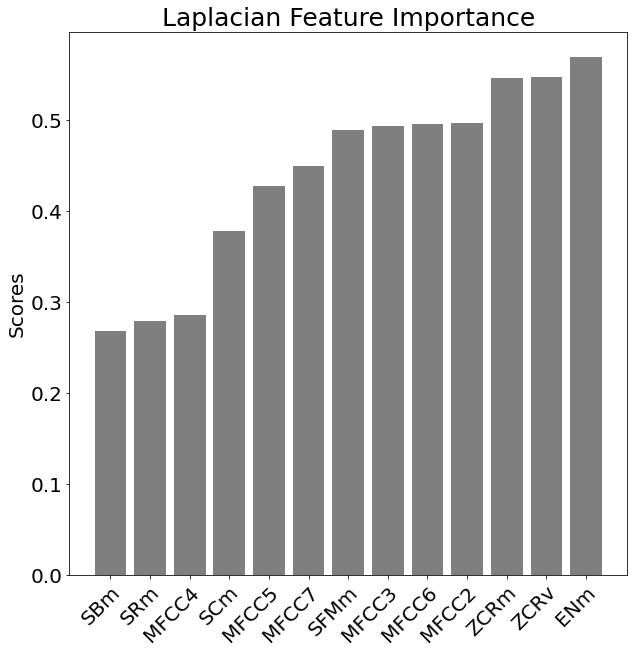

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title('Laplacian Feature Importance', size=25)
ax.bar(np.arange(selected.shape[1]), ls[laplacian[:idx]], color='black', alpha=0.5)
ax.set_xticks(np.arange(len(selected.columns)), labels=selected.columns, fontsize=20)
# Rotate the tick labels and set their alignment.
ax.set_ylabel('Scores', fontsize=20)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(fontsize=20);
# plt.savefig('laplacian.jpg')